In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

np.set_printoptions(precision=3, suppress=True, linewidth=200)

from  matplotlib.colors import LinearSegmentedColormap
cmap_yg = LinearSegmentedColormap.from_list('yg',["y", "w", "g"], N=256) 

In [2]:
class GridWorld():
  """
    A NxN grid world where each state has some reward. The location on top left
    is taken to be (0,0)

    Valid actions are At := {0, 1, 2, 3} where each element indicates the 
    direction to move as follows given you are at X,
       |   | 0 |   | 
       | 1 | X | 2 |
       |   | 3 |   |

  """
  def __init__(self, size=5, ro=0.3, r=1.0, R=100.0, source_state=[0,0], goal_state=[4,4], obs_states=[[2,1], [2,0], [3,4]], max_iter=1000):
    self.N = size # Grid Size
    self.r = r # One step reward for each state
    self.R = R # Goal reward
    self.ro = ro # Uncertainity in movement

    if (source_state[0] > self.N) or (source_state[1] > self.N):
      print('Error: pls provide a valid source state')
      exit()
    
    if (goal_state[0] > self.N) or (goal_state[1] > self.N):
      print('Error: pls provide a valid goal_state')
      exit()

    self.source_state = source_state
    self.goal_state = goal_state

    self.obs_reward = -2*R
    self.obs_states = obs_states

    # Create a reward grid
    self.reward_grid = r*np.ones((self.N, self.N))
    self.reward_grid[source_state[0], source_state[0]] = 0
    self.reward_grid[goal_state[0], goal_state[1]] = R

    # set reward for obstacles
    for obs_state in obs_states:
      self.reward_grid[obs_state[0], obs_state[1]] = self.obs_reward

    self.max_iter = max_iter

    self.action_set = [0,1,2,3]

    # Initialize transition probability dictionary
    self.transition_prob = {}
    self.populate_transition_probabilities()

  def populate_transition_probabilities(self):
    """
      Creates a transition probability matrix that defines the rules of the environment

      The transition_prob is a data structure that is indexed by [row, col, action], 
      where row, col are the location on grid.
      This indexing gives a 2D transition probabilty array for the whole grid. 
      We are assuming here that there is uncertainity only in the neighbourhood of current state.

      eg. if row is the uncertainity then, 
        [1,1,2] = np.array([
                      [   0, ro/3,    0, ...],
                      [ro/3,   X , 1-ro, ...],
                      [   0, ro/3,    0, ...],
                      [   .,    .,    ., ...],             
                      [   .,    .,    ., ...],             
                      [   .,    .,    ., ...],             
                    ]) 
      
      Note: At the corners this distribution structure will change a little, since you don't want 
            to exit the grid :)
    """
    N = self.N

    # Iterate over each state in the grid
    for i in range(N):
      for j in range(N):
        s = (i,j) # current state

        # For each action
        for a in range(4): 
          next_state_prob = np.zeros((N, N)) # transition prob matrix

          # For each action is required because we want to differentiate between movements 
          for aprime in range(4):
            if a == 0: # up
              sprime = (i - 1 if i > 0 else i, j)
            elif a == 1: # left
              sprime = (i, j - 1 if j > 0 else j)
            elif a == 2: # right
              sprime = (i, j + 1 if j < N-1 else j)
            elif a == 3: # down
              sprime = (i + 1 if i < N-1 else i, j)

            if a == aprime:
              next_state_prob[sprime[0], sprime[1]] = 1-self.ro
            else: # If we are selecting the a movement different from taken action
              if aprime == 0: # up
                ssprime = (i - 1 if i > 0 else i, j)
              elif aprime == 1: # left
                ssprime = (i, j - 1 if j > 0 else j)
              elif aprime == 2: # right
                ssprime = (i, j + 1 if j < N-1 else j)
              elif aprime == 3: # down
                ssprime = (i + 1 if i < N-1 else i, j)

              if sprime != ssprime: # If intented state is not same
                if (s == (0,0)) or (s == (N-1,0)) or (s == (0,N-1)) or (s == (N-1,N-1)): # Corner
                  next_state_prob[ssprime[0], ssprime[1]] = self.ro/2
                else:
                  next_state_prob[ssprime[0], ssprime[1]] = self.ro/3

          self.transition_prob[(s[0], s[1], a)] = next_state_prob

  def return_path(self, policy):
    N = self.N
    path = np.zeros((N, N))

    s = self.source_state
    path[s[0], s[1]] = 1

    i = 0
    while True:
      a = policy[s[0], s[1]]
      
      if a == 0: # up
        sprime = (s[0] - 1 if s[0] > 0 else s[0], s[1])
      elif a == 1: # left
        sprime = (s[0], s[1] - 1 if s[1] > 0 else s[1])
      elif a == 2: # right
        sprime = (s[0], s[1] + 1 if s[1] < N-1 else s[1])
      elif a == 3: # down
        sprime = (s[0] + 1 if s[0] < N-1 else s[0], s[1])

      path[sprime[0], sprime[1]] = 1

      if (sprime[0] == self.goal_state[0]) and (sprime[1] == self.goal_state[1]):
        break
      else:
        s = sprime

      i += 1
      if i > (N**2):
        break

    return path

In [3]:
def value_iteration(env: GridWorld, discount: float = 0.99, epsilon: float = 1e-2):
  """
    Value iteration algorithm. Policy is greedy in nature

    return: 
      Utility values - NxN array
      Policy - Dict where each key is a state and corresponding value is a valid action 
  """
  U_grid = np.zeros((env.N, env.N)) # ith Utility values
  U_grid_update = np.zeros((env.N, env.N)) # (i+1)th Utility values

  # Function to select Utility Value and corresponding best action
  def maximise(Us_grid, r, c):
    state = [r,c]
    best_action = 1
    Val = Us_grid[r,c]
    for action in env.action_set:
      NewVal = np.sum(env.transition_prob[(r,c,action)] * Us_grid)
      if NewVal > Val:
        Val = NewVal
        best_action = action
    
    return Val, best_action

  num_itr = 0
  for i in range(env.max_iter):
    num_itr += 1
    for r in range(env.N):
      for c in range(env.N):
        Val, _ = maximise(U_grid, r,c)
        U_grid_update[r,c] = env.reward_grid[r,c] + discount * Val

    # If Utility values don't change much, exit
    if np.linalg.norm(U_grid - U_grid_update) < (epsilon * (1-discount)/discount):
      break

    U_grid = U_grid_update.copy() # .copy() required since python is pass by reference 

  # Get the best policy out of the obtained Utility values
  policy = {}
  for r in range(env.N):
    for c in range(env.N):
      _, best_action = maximise(U_grid_update, r, c)
      policy[(r,c)] = best_action

  print('--- num_iterations = ', num_itr)
  return U_grid, policy

In [4]:
def policy_iteration(env: GridWorld, discount: float = 0.99):
  """
    Policy iteration algorithm. Policy is greedy in nature

    return: 
      Utility values - NxN array
      Policy - Dict where each key is a state and corresponding value is a valid action 
  """

  # Initialise a Random Policy
  policy = {}
  for i in range(env.N):
    for j in range(env.N):
      policy[(i,j)] = np.random.choice(env.action_set)

  # print('--- Initial Policy: \n', policy)

  # Function to select best action
  def policy_maximise(Us_grid, r, c):
    state = [r,c]
    best_action = 1
    Val = Us_grid[r,c]
    for action in env.action_set:
      NewVal = np.sum(env.transition_prob[(r,c,action)] * Us_grid)
      if NewVal > Val:
        Val = NewVal
        best_action = action
    
    return best_action

  num_itr = 0
  for i in range(env.max_iter):
    num_itr += 1

    # policy eval
    A = np.zeros((env.N**2, env.N**2)) # A matrix for system of linear equations
    b = env.reward_grid.flatten() # For reward vector
    for r in range(env.N):
      for c in range(env.N):
        state = c + r*env.N # Column Major Indexing

        P = env.transition_prob[(r,c, policy[(r,c)])]
        next_rc_list = np.argwhere(P).tolist() # Indices of states with non-zero prob
        for next_rc in next_rc_list:
          next_state = next_rc[1] + next_rc[0] * env.N
          A[state, next_state] += discount * P[next_rc[0], next_rc[1]]
    
    A = np.eye(env.N**2) - A # Bellman equation without max
    U_grid = np.linalg.solve(A, b).reshape((env.N, env.N))

    # policy update
    unchanged = True
    for r in range(env.N):
      for c in range(env.N):
        best_action = policy_maximise(U_grid, r, c)

        # If Expected Utility value of best_action is better than the policy, update the policy 
        if np.sum(env.transition_prob[(r,c, best_action)] * U_grid) > np.sum(env.transition_prob[(r,c, policy[(r,c)])] * U_grid):
          policy[(r,c)] = best_action
          unchanged = False

    if unchanged:
      break

  print('--- num_iterations = ', num_itr)
  # print('--- Final Policy', policy)
  # print(U_grid)
  return U_grid, policy

### Running Value Iteration ###
--- num_iterations =  138


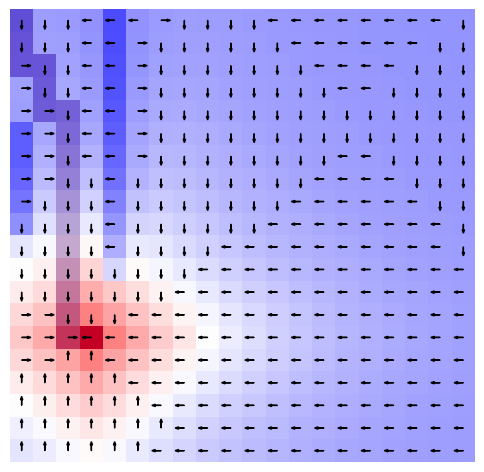

In [5]:
print('### Running Value Iteration ###')
env = GridWorld(size=20, ro=0.3, r=1.0, R=100.0, source_state=[0,0], goal_state=[14,3], obs_states=[[i,4] for i in range(12)] + [[i,0] for i in range(5,10)], max_iter=1000)
U_vals, policy = value_iteration(env, discount=0.9, epsilon=0.01)

arrows = {0:(0,1), 1:(-1,0), 2:(1,0), 3:(0,-1)}
scale = 0.25

fig, ax = plt.subplots(figsize=(6, 6))
for key in policy.keys():
  r, c = key[0], key[1]
  action = policy[key]
  plt.arrow(c+1, env.N-r, scale*arrows[action][0], scale*arrows[action][1], head_width=0.1)

source_goal = np.zeros((env.N, env.N))
source_goal[env.goal_state[0], env.goal_state[1]] = 1
source_goal[env.source_state[0], env.source_state[1]] = -1
rows,cols = U_vals.shape

path = env.return_path(policy)

plt.imshow(source_goal, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap=cmap_yg, aspect='auto', alpha=1.0)
plt.imshow(path, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap='Purples', aspect='auto', alpha=1.0)
plt.imshow(U_vals, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap='bwr', aspect='auto', alpha=0.7)
plt.axis('off')
plt.show()

### Running Policy Iteration ###
--- num_iterations =  9


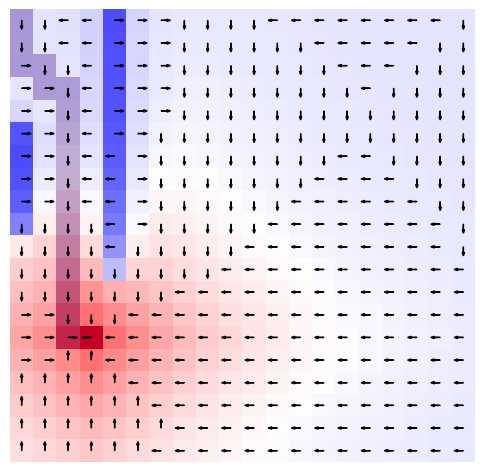

In [6]:
print('### Running Policy Iteration ###')
env = GridWorld(size=20, ro=0.3, r=1.0, R=100.0, source_state=[0,0], goal_state=[14,3], obs_states=[[i,4] for i in range(12)] + [[i,0] for i in range(5,10)], max_iter=1000)
U_vals, policy = policy_iteration(env, discount=0.9)

arrows = {0:(0,1), 1:(-1,0), 2:(1,0), 3:(0,-1)}
scale = 0.25

fig, ax = plt.subplots(figsize=(6, 6))
for key in policy.keys():
  r, c = key[0], key[1]
  action = policy[key]
  plt.arrow(c+1, env.N-r, scale*arrows[action][0], scale*arrows[action][1], head_width=0.1)

source_goal = np.zeros((env.N, env.N))
source_goal[env.goal_state[0], env.goal_state[1]] = 1
source_goal[env.source_state[0], env.source_state[1]] = -1
rows,cols = U_vals.shape

path = env.return_path(policy)

plt.imshow(source_goal, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap=cmap_yg, aspect='auto', alpha=1.0)
plt.imshow(path, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap='Purples', aspect='auto', alpha=1.0)
plt.imshow(U_vals, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap='bwr', aspect='auto', alpha=0.7)
plt.axis('off')
plt.show()

### Running Policy Iteration ###
##############################
source:  [0, 0]
goal:  [19, 0]
uncertainity:  0.1
--- num_iterations =  7


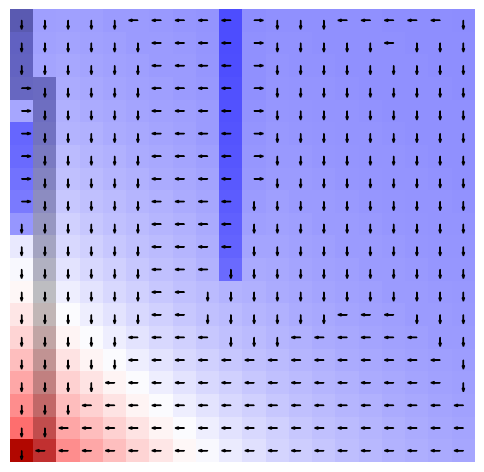

##############################
source:  [0, 0]
goal:  [0, 19]
uncertainity:  0.1
--- num_iterations =  9


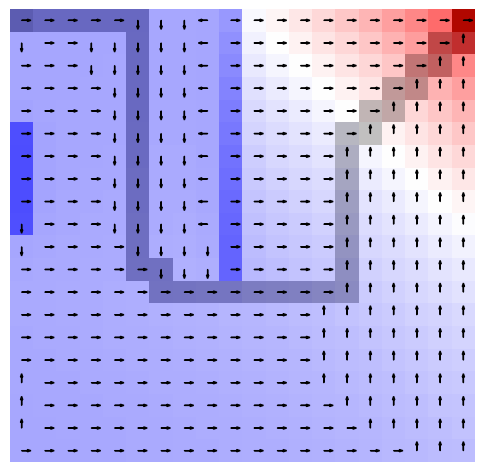

##############################
source:  [0, 0]
goal:  [19, 0]
uncertainity:  0.2
--- num_iterations =  7


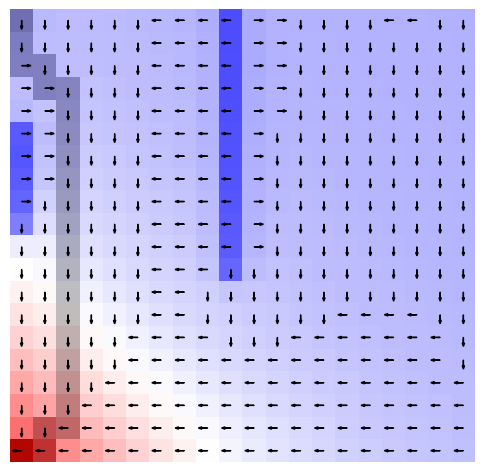

##############################
source:  [0, 0]
goal:  [0, 19]
uncertainity:  0.2
--- num_iterations =  10


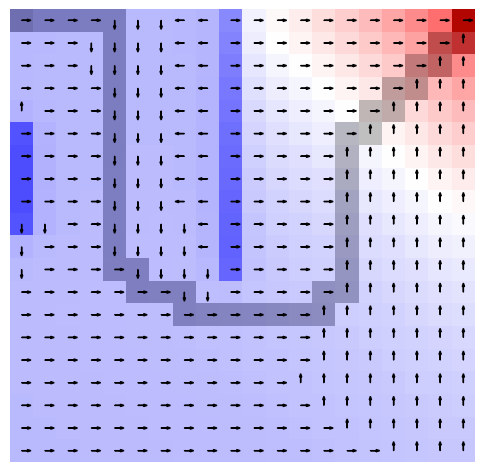

##############################
source:  [0, 0]
goal:  [19, 0]
uncertainity:  0.3
--- num_iterations =  8


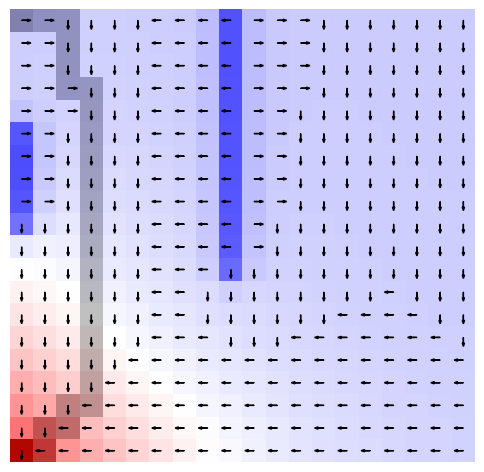

##############################
source:  [0, 0]
goal:  [0, 19]
uncertainity:  0.3
--- num_iterations =  10


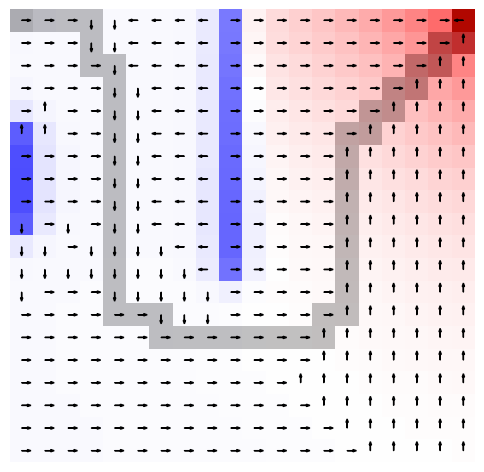

In [7]:
print('### Running Policy Iteration ###')
N = 20
uncertainities = [0.1, 0.2, 0.3]
r = 1.0
R = 100.0
source_states = [[0,0]]
goal_states = [[N-1,0], [0,N-1]]
obstacle_states = [[i,9] for i in range(12)] + [[i,0] for i in range(5,10)]
max_iter = 1000
gamma = 0.9

arrows = {0:(0,1), 1:(-1,0), 2:(1,0), 3:(0,-1)}
scale = 0.25

for ro in uncertainities:
  for source_state in source_states:
    for goal_state in goal_states:
      print('##############################')
      print('source: ', source_state)
      print('goal: ', goal_state)
      print('uncertainity: ', ro)
      env = GridWorld(size=N, ro=ro, r=r, R=R, 
                      source_state=source_state, 
                      goal_state=goal_state, 
                      obs_states=obstacle_states, 
                      max_iter=max_iter)
      U_vals, policy = policy_iteration(env, discount=gamma)

      fig, ax = plt.subplots(figsize=(6, 6))
      for key in policy.keys():
        r, c = key[0], key[1]
        action = policy[key]
        plt.arrow(c+1, env.N-r, scale*arrows[action][0], scale*arrows[action][1], head_width=0.1)

      source_goal = np.zeros((env.N, env.N))
      source_goal[env.goal_state[0], env.goal_state[1]] = 1
      source_goal[env.source_state[0], env.source_state[1]] = -1
      rows,cols = U_vals.shape

      path = env.return_path(policy)

      plt.imshow(source_goal, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap=cmap_yg, aspect='auto', alpha=1.0)
      plt.imshow(path, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap='Greys', aspect='auto', alpha=0.8)
      plt.imshow(U_vals, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows], cmap='bwr', aspect='auto', alpha=0.7)
      plt.axis('off')
      plt.show()